In [1]:
%cd /mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn
# reload and re-train to full convergence
%run notebooks/reload
%matplotlib inline

from src.kinetic_model import KineticModel, modelSpace_to_modelParams
from src.neural_network_builder import KineticNeuralNetworkBuilder
from notebooks.runAmber_kinn import get_uniform_ms, get_finkelstein_ms, get_data

import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import shutil
import os
import pickle
import gc
from sklearn.model_selection import train_test_split

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


Using TensorFlow backend.


0.1.1-ga


In [2]:
wd = "outputs/KINN-wtCas9_cleave_rate_log-finkelstein-0/"
target = "wtCas9_cleave_rate_log"

res = get_data(target=target)
# unpack data tuple
x_train, y_train, x1, y1, x_test, y_test, x2, y2 = res

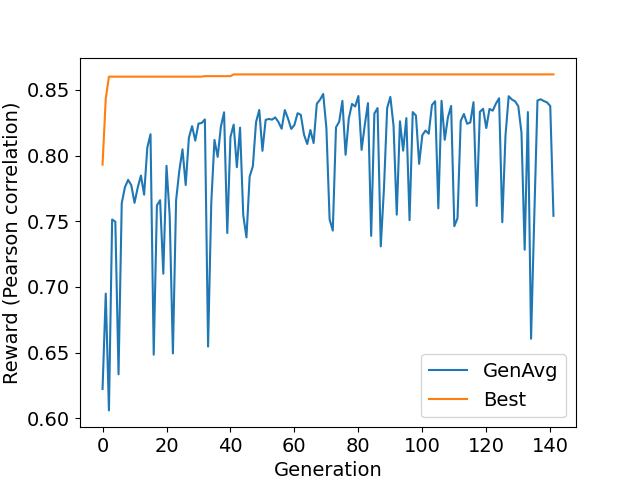

In [3]:
from IPython.display import Image

Image(filename=os.path.join(wd, "reward_vs_time.png"), width=400)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


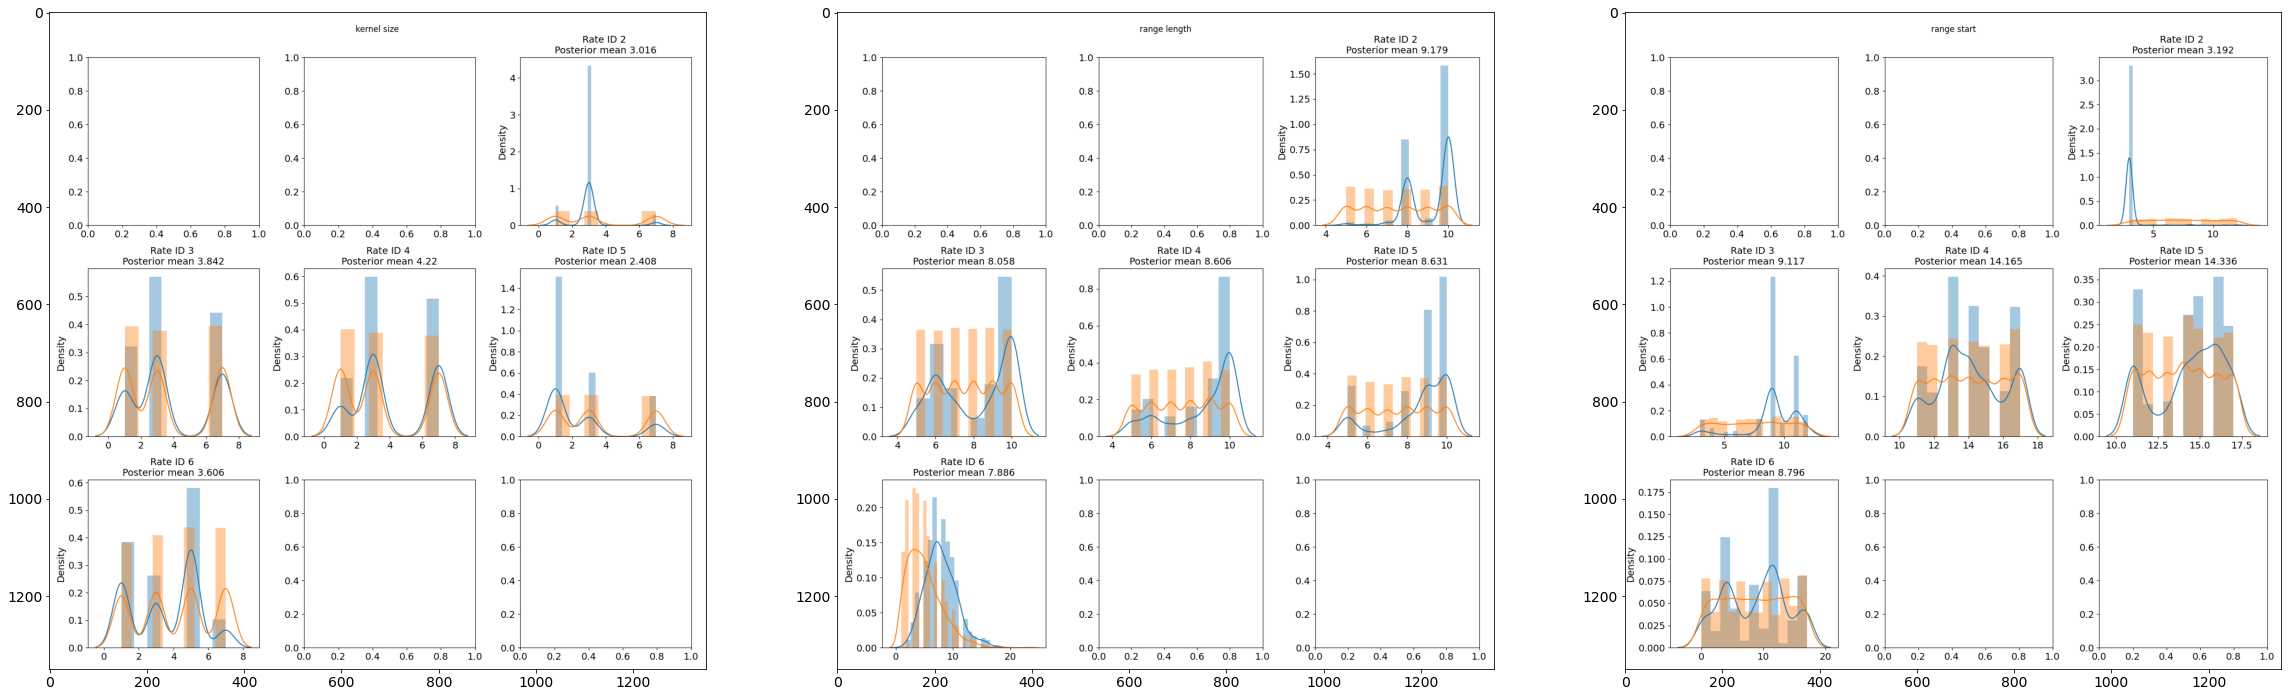

In [4]:
import matplotlib.image as mpimg

plt.figure(figsize=(40,40))
columns = 3
images = [mpimg.imread(os.path.join(wd,x)) for x in sorted([x for x in os.listdir(wd) if x.endswith("png") and x!="reward_vs_time.png"])]
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [5]:
kinn_model_space = get_finkelstein_ms()
print(kinn_model_space)

StateSpace with 7 layers and 1 total combinations


In [6]:
mb = reload_from_dir(wd, replace_conv_by_fc=True, n_channels=9)
model = mb.model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0_3 (InputLayer)          [(None, 3, 9)]       0                                            
__________________________________________________________________________________________________
input_3_13 (InputLayer)         [(None, 10, 9)]      0                                            
__________________________________________________________________________________________________
input_11_17 (InputLayer)        [(None, 6, 9)]       0                                            
__________________________________________________________________________________________________
input_15_24 (InputLayer)        [(None, 9, 9)]       0                                            
______________________________________________________________________________________________

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


spearman SpearmanrResult(correlation=0.7713712841943567, pvalue=0.0)
pearson (0.8617073867287098, 0.0)


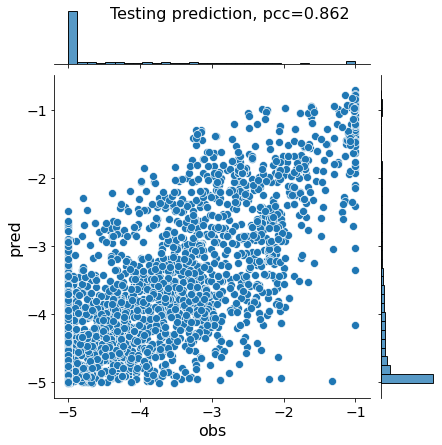

In [7]:
x_train_b = mb.blockify_seq_ohe(x_train)
x_test_b = mb.blockify_seq_ohe(x_test)

y_hat = model.predict(x_test_b).flatten()
test_pcc_old = ss.pearsonr(y_hat, y_test)[0]

h = sns.jointplot(y_test, y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test))
p = ss.pearsonr(y_hat, y_test)
print("pearson", p)
h.fig.suptitle("Testing prediction, pcc=%.3f"%test_pcc_old, fontsize=16)
plt.show()


In [8]:
checkpointer = ModelCheckpoint(
    filepath=os.path.join(wd,"bestmodel_retrain.h5"), mode='min', verbose=0, save_best_only=True,
    save_weights_only=True)
earlystopper = EarlyStopping(
    monitor="val_loss",
    mode='min',
    patience=15,
    verbose=0)

model.fit(x_train_b, y_train,
          batch_size=32,
          validation_data=(x_test_b, y_test),
          callbacks=[checkpointer, earlystopper],
          epochs=500, verbose=2)
model.load_weights(os.path.join(wd,"bestmodel_retrain.h5"))


Train on 6289 samples, validate on 5604 samples
Epoch 1/500
6289/6289 - 1s - loss: 0.2299 - val_loss: 0.3626
Epoch 2/500
6289/6289 - 1s - loss: 0.2288 - val_loss: 0.3634
Epoch 3/500
6289/6289 - 1s - loss: 0.2277 - val_loss: 0.3535
Epoch 4/500
6289/6289 - 1s - loss: 0.2274 - val_loss: 0.3651
Epoch 5/500
6289/6289 - 1s - loss: 0.2263 - val_loss: 0.3644
Epoch 6/500
6289/6289 - 1s - loss: 0.2249 - val_loss: 0.3640
Epoch 7/500
6289/6289 - 1s - loss: 0.2250 - val_loss: 0.3627
Epoch 8/500
6289/6289 - 1s - loss: 0.2237 - val_loss: 0.3620
Epoch 9/500
6289/6289 - 1s - loss: 0.2236 - val_loss: 0.3617
Epoch 10/500
6289/6289 - 1s - loss: 0.2227 - val_loss: 0.3589
Epoch 11/500
6289/6289 - 1s - loss: 0.2216 - val_loss: 0.3560
Epoch 12/500
6289/6289 - 1s - loss: 0.2219 - val_loss: 0.3631
Epoch 13/500
6289/6289 - 1s - loss: 0.2207 - val_loss: 0.3525
Epoch 14/500
6289/6289 - 1s - loss: 0.2202 - val_loss: 0.3619
Epoch 15/500
6289/6289 - 1s - loss: 0.2195 - val_loss: 0.3560
Epoch 16/500
6289/6289 - 1s - l

In [9]:
y_hat = model.predict(x_test_b).flatten()
test_pcc = ss.pearsonr(y_hat, y_test)[0]
test_pcc

0.8595458870174153

spearman SpearmanrResult(correlation=0.7736512594370121, pvalue=0.0)
pearson (0.8592082161969374, 0.0)


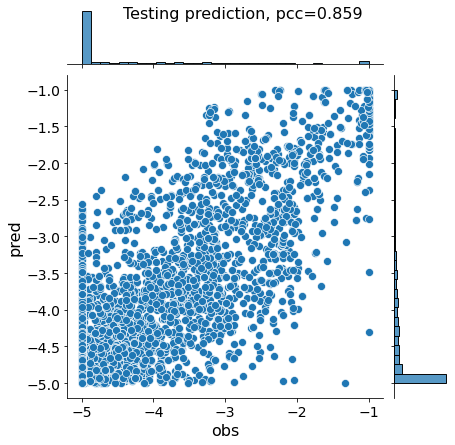

In [10]:
x_test_b = mb.blockify_seq_ohe(x_test)
y_hat = model.predict(x_test_b).flatten()
y_hat = np.clip(y_hat, -5, -1)
h = sns.jointplot(y_test, y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test))
p = ss.pearsonr(y_hat, y_test)
print("pearson", p)
h.fig.suptitle("Testing prediction, pcc=%.3f"%p[0], fontsize=16)
plt.show()

In [11]:
if test_pcc_old >= test_pcc:
    model.load_weights(os.path.join(wd, "AmberSearchBestModel.h5"))
    print("retraining is overfitting; load from amber search")
else:
    print("retraining improves the model")

retraining is overfitting; load from amber search


spearman SpearmanrResult(correlation=0.773421208390963, pvalue=2.8848410481304853e-279)
pearson (0.8593167788980935, 0.0)


Text(0.5, 0.98, 'sgRNA 2 - Test prediction, pcc=0.859')

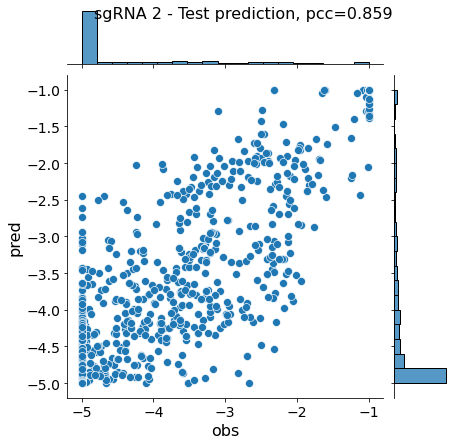

In [12]:
y_val_hat = model.predict(mb.blockify_seq_ohe(x2)).flatten()
y_val_hat = np.clip(y_val_hat, -5, -1)

h = sns.jointplot(y2, y_val_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_val_hat, y2))
p = ss.pearsonr(y_val_hat, y2)
print("pearson", p)
h.fig.suptitle("sgRNA 2 - Test prediction, pcc=%.3f"%p[0], fontsize=16)

spearman SpearmanrResult(correlation=0.8607779811396262, pvalue=1.3056476524936835e-206)
pearson (0.9442045826421374, 0.0)


Text(0.5, 0.98, 'sgRNA 1 - Test prediction, pcc=0.944')

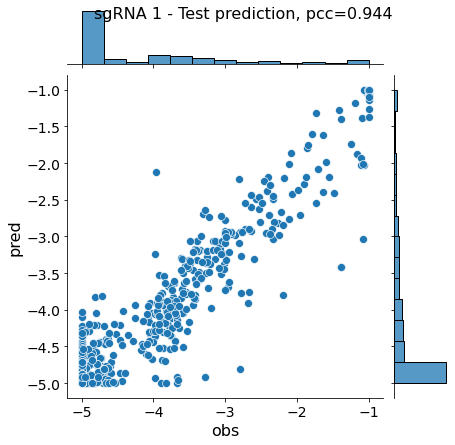

In [13]:
y_hat2 = model.predict(mb.blockify_seq_ohe(x1)).flatten()
y_hat2 = np.clip(y_hat2, -5, -1)

h = sns.jointplot(y1, y_hat2)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat2, y1))
p = ss.pearsonr(y_hat2, y1)
print("pearson", p)
h.fig.suptitle("sgRNA 1 - Test prediction, pcc=%.3f"%p[0], fontsize=16)

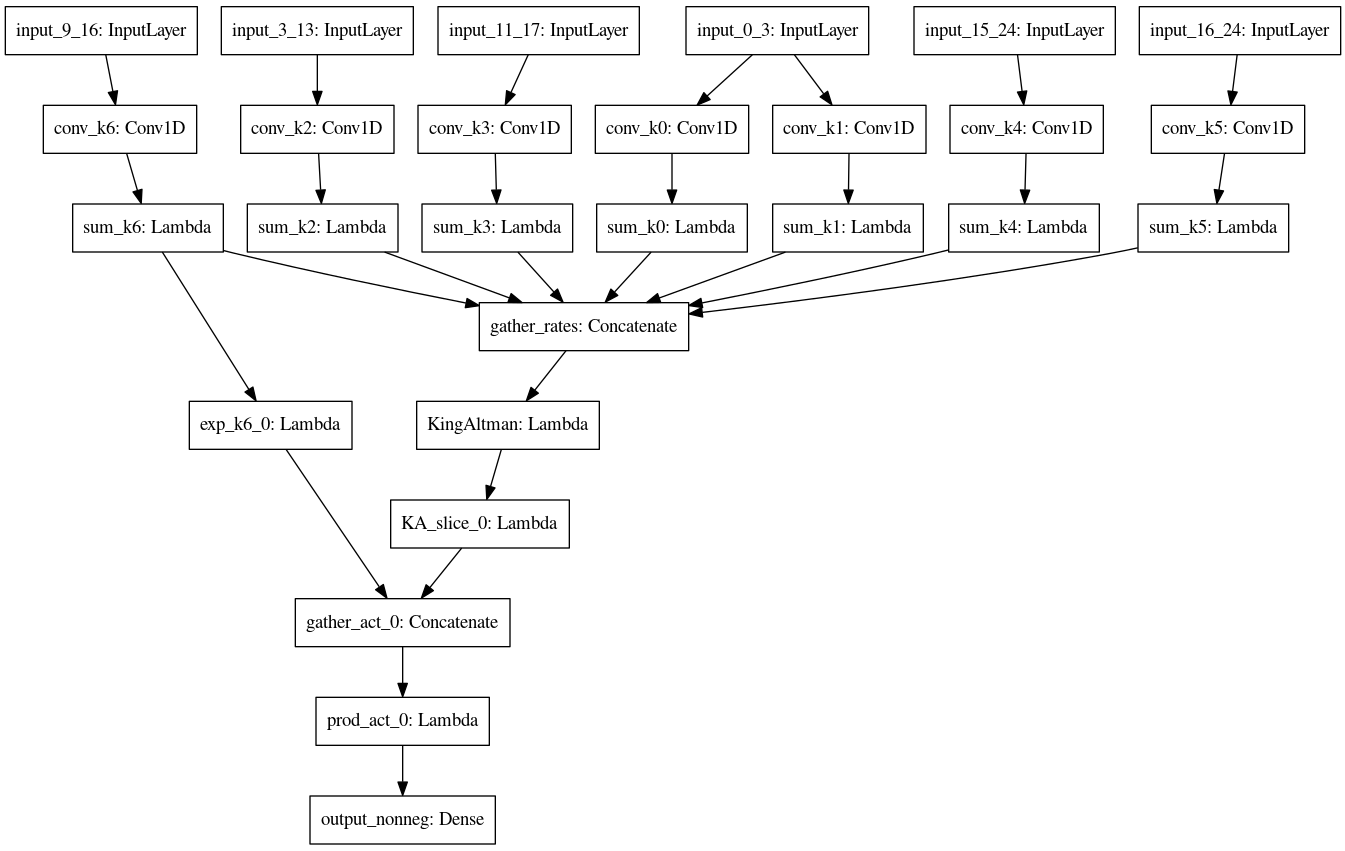

In [14]:
tf.keras.utils.plot_model(model)

In [15]:
mb.kinn.get_ka_pattern_mat()

array([[1., 0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0.],
       [1., 0., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0., 1., 0.]])

In [16]:
layer_dict = {l.name:l for l in model.layers}

In [17]:
rate_mod = tf.keras.models.Model(inputs=model.inputs, outputs=
                                 [layer_dict["sum_k%i"%k].output for k in range(7)])

print('sgRNA1\n', x_train[1,0:8, 0:4])
print('sgRNA2\n', x_train[0,0:8, 0:4])

In [18]:
#matched = np.concatenate([x_train[[1,0], :, 0:4], np.zeros((2,25,4))], axis=-1)
matched = np.zeros((1,25,9))
matched_b = mb.blockify_seq_ohe(matched)
matched_b[0]

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [19]:
model.predict(matched_b)

array([[-0.9429765]], dtype=float32)

In [20]:
a = rate_mod.predict(matched_b)
print("   sgRNA_1   snRNA_2")
for i in range(7):
    r = a[i]
    print("k_%i"%i, r.flatten())
# activity
#print("act", a[7].flatten())

   sgRNA_1   snRNA_2
k_0 [0.5656782]
k_1 [1.0493703]
k_2 [4.1821346]
k_3 [2.2661908]
k_4 [3.8973014]
k_5 [2.9280906]
k_6 [5.1530113]


In [21]:
r = rate_mod.predict([x_test_b[i] for i in range(len(x_train_b))])

In [22]:
y_test[0:20]

array([-4.01737231, -5.        , -1.31841978, -5.        , -4.89942379,
       -5.        , -4.97303295, -4.76904831, -5.        , -4.19818628,
       -1.        , -5.        , -3.03342372, -2.37021421, -3.99099823,
       -5.        , -4.63544512, -5.        , -4.23259227, -5.        ])

In [31]:
i = 12
{"k%i"%_:r[_][i][0] for _ in range(len(r))}

{'k0': 0.5656782,
 'k1': 1.0493703,
 'k2': 2.2007155,
 'k3': 2.2661908,
 'k4': 2.6401057,
 'k5': 5.5354385,
 'k6': 5.1530113}

In [32]:
# OLD CODE WHEN INCLUDING REF SEQ LETTERS
#def pretty_print(mat):
#    for i, r in enumerate(mat):
#        h, t = r[0:4], r[4:]
#        try:
#            ref = 'ACGT'[np.where(h==1)[0][0]]
#        except:
#            continue
#        if sum(t) == 0:
#            edit = ''
#        else:
#            edit = '->' + 'ACGT'[np.where(t==1)[0][0]]
#
#        print('row %i\t'%i, ref, edit)
#        #print('row ', i, r)

In [33]:
def pretty_print(mat):
    for i, r in enumerate(mat):
        sub, indel = r[0:4], r[4:]
        if sum(sub) == 0:
            s = ''
        else:
            s = 'sub:' + 'ACGT'[np.where(sub==1)[0][0]]
        if sum(indel) == 0:
            ind = ''
        else:
            ind = 'indel:' + 'ACGT-'[np.where(indel==1)[0][0]]
        
        if not s and not ind:
            m = "match"
        else:
            m = ''
        print('row %i\t'%i, m, s, ind)
        #print('row ', i, r)

pretty_print(x_test[i])

row 0	 match  
row 1	 match  
row 2	 match  
row 3	 match  
row 4	 match  
row 5	 match  
row 6	 match  
row 7	 match  
row 8	  sub:A 
row 9	 match  
row 10	 match  
row 11	 match  
row 12	 match  
row 13	 match  
row 14	 match  
row 15	 match  
row 16	 match  
row 17	  sub:T 
row 18	 match  
row 19	 match  
row 20	 match  
row 21	 match  
row 22	 match  
row 23	 match  
row 24	 match  


In [34]:
print("obs ", y_test[i], "; pred ",y_hat[i])

obs  -3.033423718 ; pred  -3.2624586
